# Семинар 1. Векторизация текстов

Научимся извлекать из текстов признаки.


- Узнаете, что такое мешок слов и N-граммы.
- Освоите метод вычисления признаков TF-IDF.
- Построите модель для классификации текстов.
---



## Лемматизация

Прежде чем извлечь признаки из текста, упростим его.<br>

Рассмотрим этапы предобработки текста:<br>
- **Токенизация (англ. tokenization)** — разбиение текста на токены: отдельные фразы, слова, символы.
- **Лемматизация (англ. lemmatization)** — приведение слова к начальной форме — лемме.<br>

Функция лемматизации русского текста есть в библиотеках:
- `pymorphy2` (англ. python morphology, «морфология для Python»)
- `UDPipe` (англ. universal dependencies pipeline, «конвейер для построения общих зависимостей»),
- `pymystem3`.<br>


Рассмотрим, как работать с библиотекой `pymystem3`.<br>

Создадим класс для лемматизации:

In [ ]:
from pymystem3 import Mystem
m = Mystem()

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Функции `lemmatize()` передадим «лемматизируй это»:

In [ ]:
m.lemmatize("лемматизируй это")

['лемматизировать', ' ', 'это', '\n']

Функция вернула лемму каждого слова. Для функции конец строки — это тоже знак, поэтому находится и его лемма `(\n)` (от англ. new line, «новая строка»):

Функцией `join()` объединим элементы списка в строку, разделив их пробелом (но можно и без него):

In [ ]:
" ".join(['лемматизировать', ' ', 'это', '\n'])

'лемматизировать   это \n'

В этой теме мы будем работать с русскоязычным корпусом коротких текстов RuTweetCorp.<br>

Перед вами уменьшенный датасет — 5000 записей. Каждая запись содержит текст поста и оценку его тональности. Если пост позитивный, то метка «1», если негативный — «0».

In [ ]:
# импортируем данные
import pandas as pd
data = pd.read_csv('tweets.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'tweets.csv'

In [ ]:
data.head()

Чтобы алгоритмы умели определять тематику и тональность текста, их нужно обучить на ***корпусе***. Это набор текстов, в котором эмоции и ключевые слова уже размечены.<br>


Создадим корпус постов. Преобразуем столбец `'text'` в список текстов. Переведём тексты в стандартный для `Python` формат: кодировку `Unicode U`.
Изменим кодировку методом `astype()`:

In [ ]:
corpus = data['text'].values.astype('U')

In [ ]:
corpus[:3]

### Задание 1

Напишите функцию `lemmatize(text)`. На вход она принимает текст из корпуса и возвращает лемматизированную строку. Возьмите первый текст из датасета `tweets.csv`. Код напечатает на экране исходный и лематизированный тексты.

In [ ]:
# ваше решение
print(corpus[0])
text = m.lemmatize(corpus[0])
print(' '.join(text))

## Регулярные выражения

От лишних символов текст очистят ***регулярные выражения*** (англ. regular expressions)<br>


Это инструмент для поиска слова или числа по шаблону (англ. pattern). Он определяет, из каких частей состоит строка и какие в них символы. Например, нужно найти все даты в таком формате записи: 02.02.2020. Их шаблон — это два числа, точка, два числа, точка, четыре числа. <br>
Шаблон для email-адреса такой: строка на латинице, символ @, строка на латинице, точка, строка на латинице.<br>

Для работы с регулярными выражениями в `Python` есть встроенный модуль `re` (сокр. от regular expressions):

In [ ]:
import re

Познакомимся с функцией `re.sub()` (от англ. substitute, «заменять»). Она находит в тексте все совпадения по шаблону и заменяет их заданной строкой.

```
# pattern — шаблон
# replacement — на что заменять
# text — текст, в котором искать совпадения
re.sub(pattern, replacement, text)
```

Вернёмся к нашей задаче. В лемматизированном тексте твита нужно оставить только кириллические символы и пробелы. Чтобы их найти, напишем регулярное выражение.<br>

Оно начинается с символа `r`, заключается в кавычки и квадратные скобки:
```
r'[]'
```

В квадратных скобках перечисляют все символы, подходящие под шаблон (в любом порядке, без пробелов). Запишем, что ищем буквы от «а» до «я». Они могут быть как в нижнем, так и верхнем регистрах, поэтому получаем:
```
# диапазон букв обозначается дефисом:
# а-я — это то же самое, что абвгдежзийклмнопрстуфхцчшщъыьэюя
r'[а-яА-Я]'
```

Поскольку `Python` не знает, что буква Ё должна входить в диапазон, добавим её в нижнем и верхнем регистрах:
```
r'[а-яА-ЯёЁ]'
```

Возьмём исходный текст твита. Под наш шаблон подходят кириллические символы и пробелы, которые как раз нужно оставить. Но если мы вызовем функцию `re.sub()`, их заменят пробелы. Чтобы указать, что символы под шаблон не подходят, перед набором символов поставим знак «домика» (^):

In [ ]:
# уже лемматизированный текст
text = "@first_timee хоть я и школота, но поверь, у мы то же самый :d общество профилировать предмет типа)"
re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)

Так в тексте остались только кириллические символы и пробелы. После этой операции в тексте можно обнаружить лишние пробелы, для анализа они — помеха. Пробелы устраняются комбинацией функций `join()` и `split()`.<br>


Возьмём пример текста с лишними пробелами: в середине, начале и конце строки. Методом `split()` преобразуем его в список. Если не указывать аргументы у `split()`, он делает разбиение по пробелам или группам пробелов:

In [ ]:
text = "            хоть я и школота  но поверь  "
text.split()

In [ ]:
" ".join(['хоть', 'я', 'и', 'школота', 'но', 'поверь'])

### Задание 2

Напишите функцию `clear_text(text)`, которая оставит в тексте только кириллические символы и пробелы. На вход она принимает текст, а возвращает очищенный текст. Дополнительно уберите лишние пробелы.

In [ ]:
# ваше решение
def clear_text(text):
  text = re.sub(r'[^а-яА-ЯёЁ ]', ' ', text)
  text = text.split()
  text = " ".join(text)
  return text

print(clear_text(text))

## Мешок слов и N-граммы

Переведём тексты в понятный для машины формат — векторный.<br>

Преобразовать слова в векторы поможет модель ***«мешок слов»*** (англ. bag of words). Она преобразует текст в вектор, не учитывая порядок слов. Отсюда и название — «мешок».<br>

Возьмём начало стихотворения Игоря Северянина:
```
Ананасы в шампанском! Ананасы в шампанском!
Удивительно вкусно, искристо и остро!
```

Лемматизируем его:
```
ананас в шампанский
ананас в шампанский
удивительно вкусно искристый и остро
```

Посчитаем количество вхождений каждого слова:
- «ананас», «в», «шампанский» — по 2 раза;
- «удивительно», «вкусно», «искристый», «и», «остро» — по 1 разу.<br>

Получили такой результат:

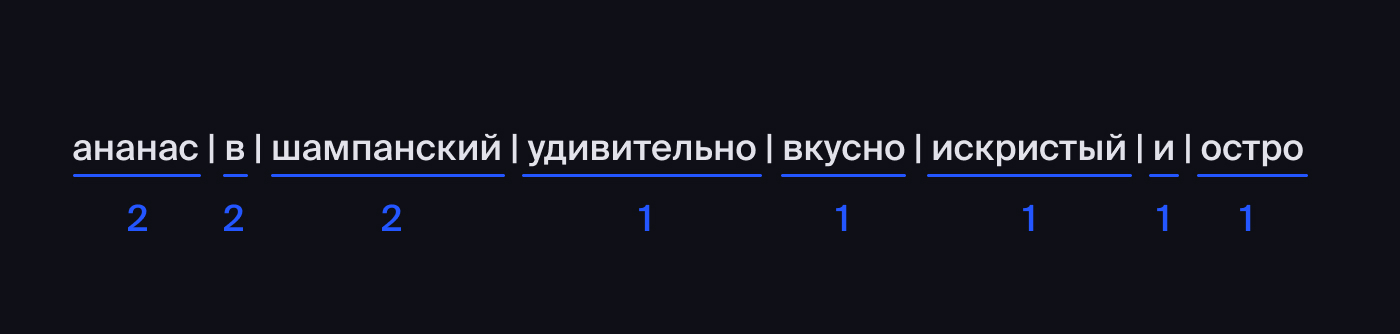

Вектор этого текста:
```
[2, 2, 2, 1, 1, 1, 1, 1]
```

Когда текстов несколько, мешок слов преобразует их в матрицу. Её строки — это тексты, а столбцы — уникальные слова из всех текстов корпуса. Числа на пересечении строк и столбцов показывают, сколько раз в тексте встречается уникальное слово.

### Задание 3

Перед вами корпус. Какой вектор описывает лемматизированный текст **«видеть Гpека в pека pак»**:
```
[
  'ехать Гpека чеpез pека',
  'видеть Гpека в pека pак',
  'сунуть Гpека pука в pека',
  'pак за pука Гpека цап'
]
```
Последовательность слов для вектора такая:
```
['ехать', 'Гpека', 'чеpез', 'pека', 'видеть', 'в', 'pак', 'сунуть', 'pука', 'за', 'цап']
```

In [ ]:
# ваше решение
[0,1,0,1,1,1,1,0,0,0]

В мешке слов учитывается каждое уникальное слово. Но порядок слов и связи между ними не учитываются. Например, есть такой лемматизированный текст:
```
Фёдор ехать из Москва в Петербург
```

Его набор слов: «Фёдор», «ехать», «Москва», «Петербург», «из», «в». Так куда едет Фёдор? Чтобы ответить на вопрос, посмотрим на словосочетания, или ***N-граммы*** (англ. N-grams).<br>

***N-грамма*** — это последовательность из нескольких слов. N указывает на количество элементов и может быть любым. Например, если N равно 1, получаются слова, или ***униграммы*** (лат. unus, «один»). При N=2 выходят словосочетания из двух слов — ***биграммы*** (лат. bis, «дважды»). Если N=3, то это уже ***триграммы*** (лат. tres, **«три»), т. е. из трёх слов.<br>

Как выглядят триграммы предложения «В сто сорок солнц закат пылал»?

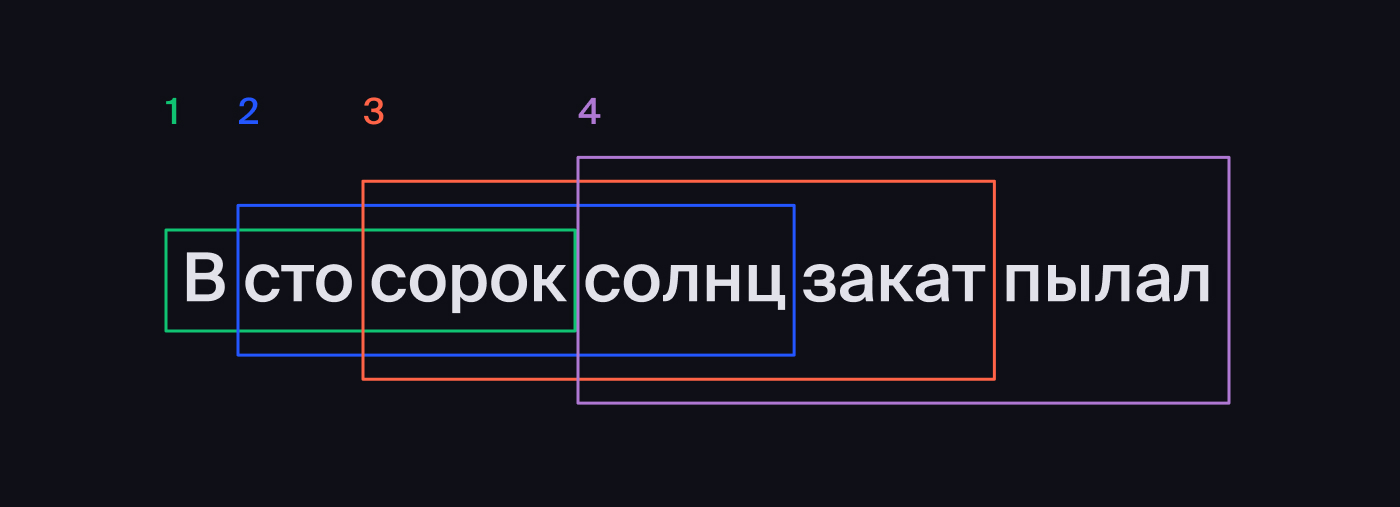

Мы получили четыре триграммы: «в сто сорок», «сто сорок солнц», «сорок солнц закат», «солнц закат пылал». Слово «закат» не может быть началом следующей триграммы: после него остаётся только одно слово, а нужно два.<br>

Вернёмся к нашему Фёдору и найдём в тексте биграмму. Получится такой набор: «Фёдор ехать», «ехать из», «из Москвы», «Москвы в», «в Петербург». Всё теперь ясно: точки А и Б найдены. Фёдор отправился из Москвы в Петербург.<br>

Аналогично модели «мешок слов» N-граммы текста можно преобразовывать в векторы. Например, вектор для текста о Фёдоре выглядит так:

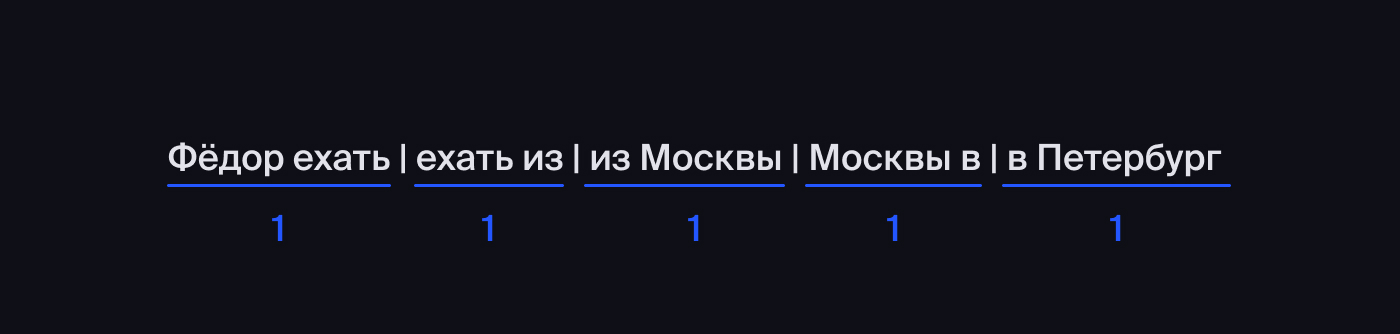

### Задание 4

Сколько биграмм получится из цитаты Даниила Хармса. N-грамма не должна разбиваться точкой:
```
'Предмет обезоружен. Он стручок. Вооружена только куча.'
```

In [ ]:
# ваше решение
4

## Создание мешка слов

Научимся создавать мешок слов и находить ***стоп-слова*** (англ. stopwords).<br>

Чтобы преобразовать корпус текстов в мешок слов, обратимся к классу `CountVectorizer()` (англ. count vectorizer, «счётчик слов для создания векторов»). Он находится в модуле `sklearn.feature_extraction.text` (англ. «построение признаков текста»). <br>

Импортируем его:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# создадим счётчик
count_vect = CountVectorizer()

Передадим счётчику корпус текстов. Для этого вызовем функцию `fit_transform()`. Счётчик выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса. Отдельные буквы счётчик как слова не учитывает.

In [ ]:
# bow, от англ. bag of words
bow = count_vect.fit_transform(corpus)

Метод вернёт матрицу, в которой одна строка — это текст, а столбец — уникальное слово из всего корпуса. Число на их пересечении покажет, сколько раз в тексте встречалось нужное слово.<br>

Из прошлого урока возьмём корпус про Греку:

In [ ]:
corpus = [
    'ехать Гpека чеpез pека',
    'видеть Гpека в pека pак',
    'сунуть Гpека pука в pека',
    'pак за pука Гpека цап'
]

Создадим для него мешок слов. Чтобы получить размер матрицы, посмотрим атрибут `shape`:

In [ ]:
bow = count_vect.fit_transform(corpus)
bow.shape

In [ ]:
# представим мешок слов в иде матрицы
print(bow.toarray())

Список уникальных слов в мешке образует ***словарь***. Он хранится в счётчике и вызывается методом `get_feature_names_out()` (англ. «получить имена признаков»):

In [ ]:
count_vect.get_feature_names_out()

`CountVectorizer()` также нужен для расчёта N-грамм. Чтобы он считал словосочетания, укажем размер N-граммы через аргумент `ngram_range` (англ. «диапазон N-грамм»). Например, если мы ищем словосочетания по два слова в фразе, то диапазон зададим такой:

In [ ]:
count_vect = CountVectorizer(ngram_range=(2, 2))

Со словосочетаниями счётчик работает так же, как и со словами.<br>

У больших корпусов и мешки слов выходят большие, но часть слов в них может быть бессмысленной. Например, что можно сказать о тексте по местоимениям, союзам и предлогам? Чаще всего от них можно избавиться, причём тема текста и смысл предложения не изменятся. Когда мешок слов меньше и чище, проще найти слова, важные для классификации текстов.<br>

Чтобы почистить мешок слов, найдём ***стоп-слова***, то есть слова без смысловой нагрузки. Их много, и для каждого языка — свои. Разберём пакет `stopwords`, который находится в модуле `nltk.corpus` библиотеки `nltk` (англ. Natural Language Toolkit, «инструментарий естественного языка»):

In [ ]:
from nltk.corpus import stopwords

Чтобы пакет заработал, загрузим список стоп-слов:

In [ ]:
import nltk
nltk.download('stopwords')

Вызовем функцию `stopwords.words()`, передадим ей аргумент `'russian'`, то есть русскоязычные стоп-слова:

In [ ]:
stop = list(set(stopwords.words('russian')))

При создании счётчика передадим список стоп-слов в счётчик векторов `CountVectorizer()`:

In [ ]:
count_vect = CountVectorizer(stop_words=stop)

Теперь счётчик знает, какие слова нужно исключить из мешка слов.

### Задание 5

1. В таблицу `data` добавить столбец `lemm_text` с очищенными и лемматизированными текстами. Создайте два мешка слов для корпуса твитов: очищенный от стоп-слов и с ними. Напечатайте их размеры на экране.

2. Создайте счётчик N-грамм для корпуса твитов. В каждой фразе по два слова. Напечатайте на экране размер N-грамм.

In [ ]:
data_lemm = pd.read_csv('tweets_lemm.csv')
data_lemm

In [ ]:
count_vect = CountVectorizer()
bow = count_vect.fit_transform(data_lemm['lemm_text'])
print(bow.shape)

count_vect_stop = CountVectorizer(stop_words=stop)
bow_stop = count_vect_stop.fit_transform(data_lemm['lemm_text'])
print(bow_stop.shape)

count_vect_gram = CountVectorizer(ngram_range=(2, 2))
bow_gram = count_vect_gram.fit_transform(data_lemm['lemm_text'])
print(bow_gram.shape)

In [ ]:
count_vect_stop = CountVectorizer(stop_words=stop)
bow_stop = count_vect_stop.fit_transform(data_lemm['lemm_text'])
bow.shape

In [ ]:
count_vect_gram = CountVectorizer(ngram_range=(2, 2))
bow_gram = count_vect_gram.fit_transform(data_lemm['lemm_text'])
bow.shape

## TF-IDF

Мешок слов учитывает частоту употребления слов. Посмотрим, как часто уникальное слово встречается во всём корпусе и в отдельном его тексте.

Оценка важности слова определяется величиной ***TF-IDF*** (от англ. *term frequency*, «частота терма, или слова»; *inverse document frequency*, «обратная частота документа, или текста»). То есть *TF* отвечает за количество упоминаний слова в отдельном тексте, а *IDF* отражает частоту его употребления во всём корпусе.

Формула TF-IDF такая:

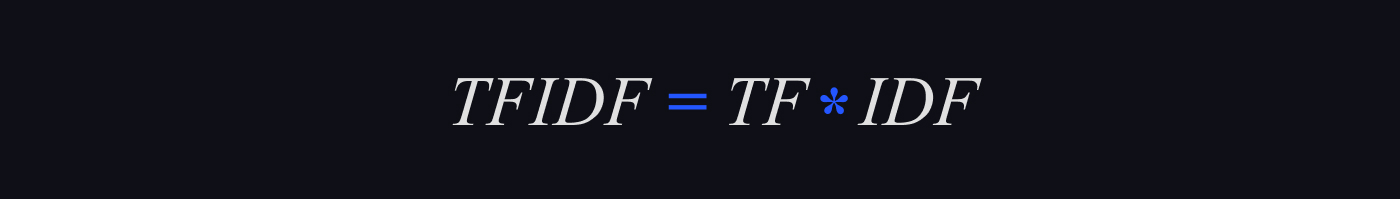

TF рассчитывается так:

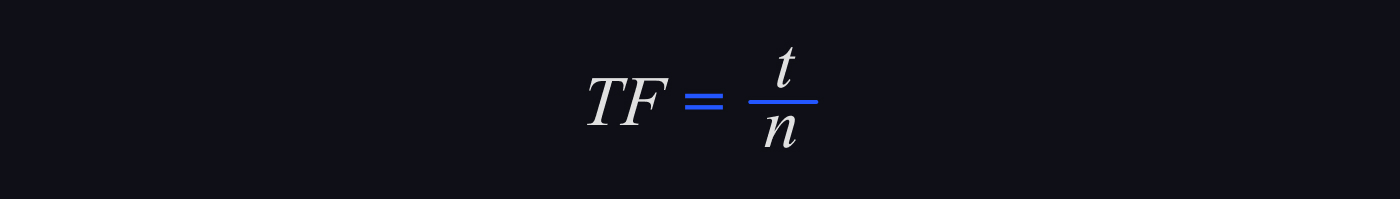

где **t** (от англ. term) — количество употребления слова, а **n** — общее число слов в тексте.

IDF нужна в формуле, чтобы уменьшить вес слов, наиболее распространённых в любом другом тексте заданного корпуса. IDF зависит от общего числа текстов в корпусе (**D**) и количества текстов, в которых это слово встречается (**d**).

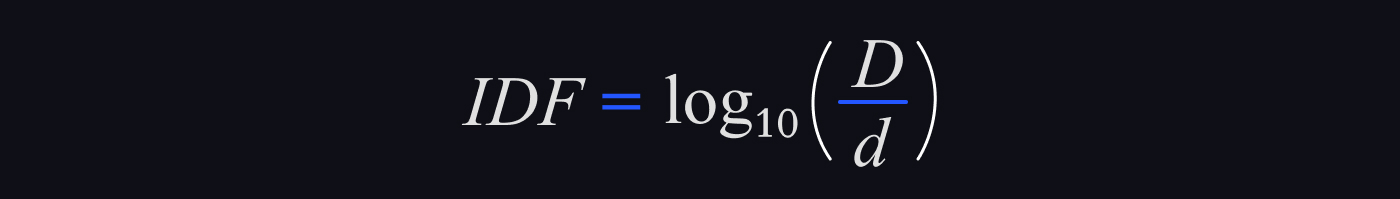

Например, рассмотрим корпус из 20-ти стихотворений. Возьмём первое: в нём 40 слов, нам интересно слово «река». В стихе оно встречается пять раз. Всего в корпусе два стихотворения с «рекой». Рассчитаем TF-IDF для слова «река» в первом стихотворении корпуса.

TF равна:

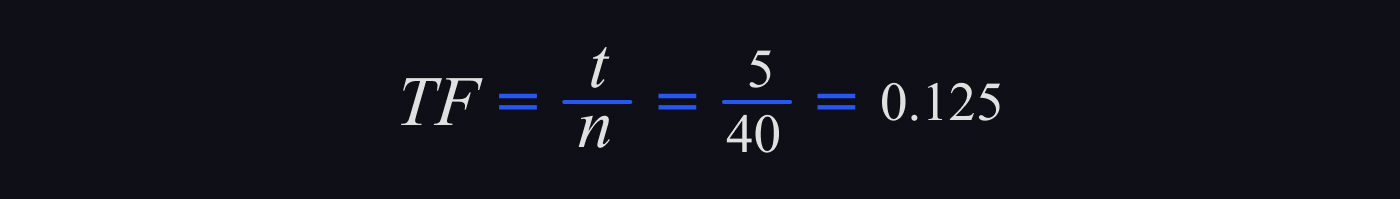

В двух из двадцати стихотворений встречается слово «река», тогда IDF равна:

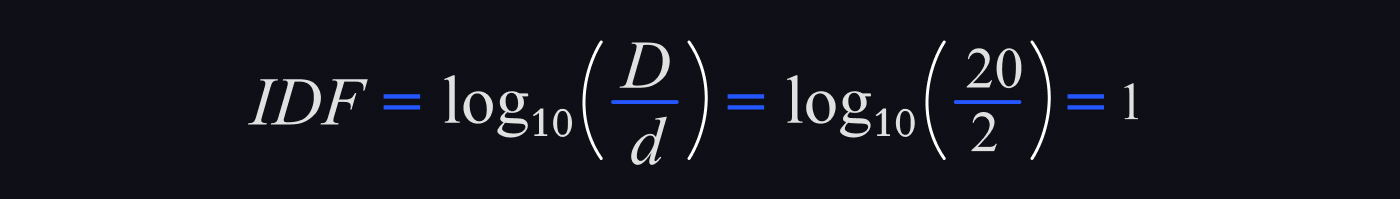

TF-IDF получается такой:

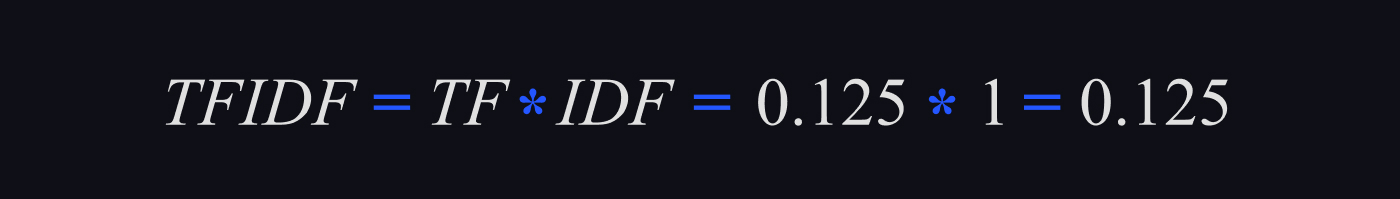

Большая величина TF-IDF говорит об уникальности слова в тексте по отношению к корпусу. Чем чаще оно встречается в конкретном тексте и реже в остальных, тем выше значение TF-IDF.

### Задание 6

Посчитайте TF-IDF для слова «коралл» в третьем тексте:
```
'Клара строго карать Карл за кража коралл'
```
Корпус такой:
```
[
    'Карл у Клара украсть коралл',
    'Клара у Карл украсть кларнет',
    'Клара строго карать Карл за кража коралл'
]
```

In [ ]:
TF = 1/7
IDF = log10(3/2) = 0.176
TF-IDF = 1/7 * 0.176 = 0.025

## TF-IDF в sklearn

Вычислим TF-IDF для корпуса текстов.

Рассчитать TF-IDF можно и в библиотеке `sklearn`. Класс `TfidfVectorizer()` (от англ. «счётчик величин TF-IDF») находится в модуле `sklearn.feature_extraction.text`. Импортируем его:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

По аналогии с `CountVectorizer()` создадим счётчик, указав в нём стоп-слова:

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop)

Чтобы посчитать TF-IDF для корпуса текстов, вызовем функцию `fit_transform()`:

In [ ]:
tf_idf = count_tf_idf.fit_transform(corpus)

Передав `TfidfVectorizer()` аргумент `ngram_range`, можно рассчитать N-граммы.
Если данные разделены на обучающую и тестовую выборки, функцию `fit()` запускайте только на обучающей. Иначе тестирование будет нечестным: в модели будут учтены частоты слов из тестовой выборки.

### Задание 7

Создайте матрицу cо значениями TF-IDF по корпусу твитов. Сохраните её в переменной `tf_idf`. Укажите стоп-слова. Напечатайте на экране размер матрицы.

In [ ]:
count_tf_idf = TfidfVectorizer(stop_words=stop)
tf_idf = count_tf_idf.fit_transform(data_lemm['lemm_text'])
tf_idf.shape

## Классификация тональности текста

Для определения тональности применим величины TF-IDF как признаки.

Анализ тональности текста, или ***сентимент-анализ*** (от англ. sentiment, «настроение»), выявляет эмоционально окрашенные слова. Этот инструмент помогает компаниям оценивать, например, реакцию на запуск нового продукта в интернете. На разбор тысячи отзывов человек потратит несколько часов, а компьютер — пару минут.

Оценить тональность — значит отметить текст как позитивный или негативный. То есть мы решаем задачу классификации, где целевой признак равен «1» для положительного текста и «0» для отрицательного. Признаки — это слова из корпуса и их величины TF-IDF для каждого текста.

### Задание 8

Обучите логистическую регрессию так, чтобы она определяла тональность текста.  
Подсчитайте величину TF-IDF для текстов. Лемматизированные тексты твитов для обучения находятся в файле `tweets_lemm_train.csv`. Целевой признак вы найдёте в столбце `positive`.

Обученной моделью классификации определите результаты предсказания для тестовой выборки твитов, которая лежит в файле `tweets_lemm_test.csv`. В этой выборке целевого признака нет. Сохраните предсказания в столбце `positive`.

Значение `accuracy` вашей модели должно быть не меньше 0.62.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
df_train = pd.read_csv('tweets_lemm.csv')
df_test = pd.read_csv('tweets_lemm_train.csv')

df_train.head()

,text,positive,lemm_text
0,"@first_timee хоть я и школота, но поверь, у на...",1,хоть я и школотый но поверь у мы то же самый о...
1,"Да, все-таки он немного похож на него. Но мой ...",1,да весь таки он немного похожий на он но мой м...
2,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,ну ты идиотка я испугаться за ты
3,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,кто то в угол сидеть и погибать от голод а мы ...
4,@irina_dyshkant Вот что значит страшилка :D\nН...,1,вот что значит страшилка но блин посмотреть ве...


In [ ]:
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(df_train['lemm_text'])
y_train = df_train['positive']

X_test_tfidf = vectorizer.transform(df_train['lemm_text'])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_val, y_pred)

print(f'Accuracy: {accuracy}')


Accuracy: 0.6427184466019418
